# Plotting NJ pollutants data

with clean up of the code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
def Prepare_Data(filename):
    df= pd.read_csv(filename)
    
    # remove unnecessary columns from the data frame
    cols = list(df.columns)
    cols_to_keep = ['Date', 'DAILY_AQI_VALUE' ]
    for c in cols:
        if 'Concentration' in c:
            cols_to_keep.append(c)
            break
    for col in cols_to_keep:
        cols.remove(col)
    df  = df.drop(columns=cols)
    df.Date = pd.to_datetime(df.Date)
    #print ( df.tail(2) )
    
    # Checking for missing dates
    # first set the index as Date
    df = df.set_index('Date')
    missing_dates = pd.date_range(df.index.min(), df.index.max()).difference(df.index)
    #print (missing_dates)
    print ('Dataset date range:', df.index.min().strftime('%Y-%m-%d'), df.index.max().strftime('%Y-%m-%d') )    
    print ('Number of missing dates in the dataset : %d / %d ' % ( len(missing_dates), df.shape[0] ) )
    
    # Fill in the missing dates
    # df = df.set_index('Date') # already done in previous part.
    # insert all the missing dates with Nans
    df = df.reindex(  pd.date_range(df.index.min(), df.index.max())  ) 
    # fill those missing dates with the last known date
    df.ffill(axis=0, inplace=True)  
    # Now move the Date index as one of the columns, easier for later analysis
    df = df.rename_axis('Date').reset_index()
    
    print ( 'After filling the missing dates: the # of missing dates:', df.isnull().any().sum() ) 
    # Train test split
    df_train = df.loc[ df.Date < datetime(2018, 1, 1)  ].copy()
    df_test  = df.loc[ df.Date >= datetime(2018, 1, 1)  ].copy()
    
    return (df, df_train, df_test)

fname='./datasets/NJ_Ozone_site_003.csv'
(df_oz, df_train_oz, df_test_oz) = Prepare_Data(fname)

Dataset date range: 2009-06-01 2020-05-24
Number of missing dates in the dataset : 80 / 3931 
After filling the missing dates: the # of missing dates: 0


In [3]:
fname='./datasets/NJ_Ozone_site_003.csv'
(df_oz, df_train_oz, df_test_oz) = Prepare_Data(fname)

Dataset date range: 2009-06-01 2020-05-24
Number of missing dates in the dataset : 80 / 3931 
After filling the missing dates: the # of missing dates: 0


In [4]:
df_oz.head(2)

,Date,Daily Max 8-hour Ozone Concentration,DAILY_AQI_VALUE
0,2009-06-01,0.043,40.0
1,2009-06-02,0.044,41.0


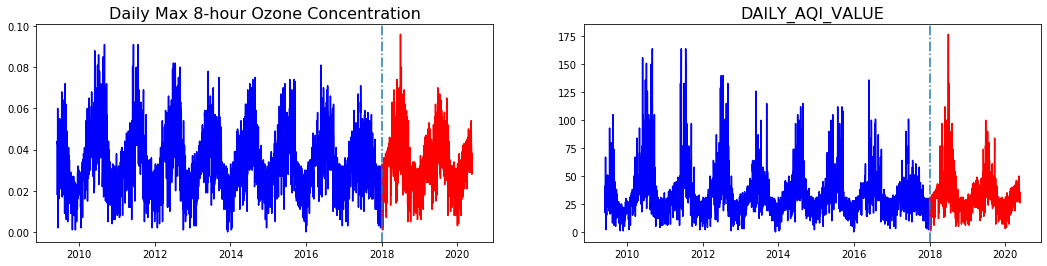

In [17]:
def Plot_train_test(df, df_train, df_test):
    cols = list(df.columns)
    cols.remove('Date')
    
    plt.figure(figsize=(18,4))
    for i, col in enumerate(cols):
        plt.subplot(121+i)
        plt.title(col, fontsize=16)
        plt.plot(df_train.Date, df_train[col], color='blue')
        plt.plot(df_test.Date, df_test[col], color='red')
        plt.axvline(x=datetime(2018, 1, 1), ls='-.' )

Plot_train_test(df_oz, df_train_oz, df_test_oz)
    

In [21]:
def seasonal_naive2(df, df_train, df_test, n_period, cols):
    df_pred = df.copy()
    for date in df_test.Date.values:
        indx = df_pred.loc[ df.Date == date  ].index[0] - int( n_period*365) 
        for col in cols:
            preds = df_pred[col][indx]
            df_pred.loc[ df.Date == date, col ] = preds
    return df_pred

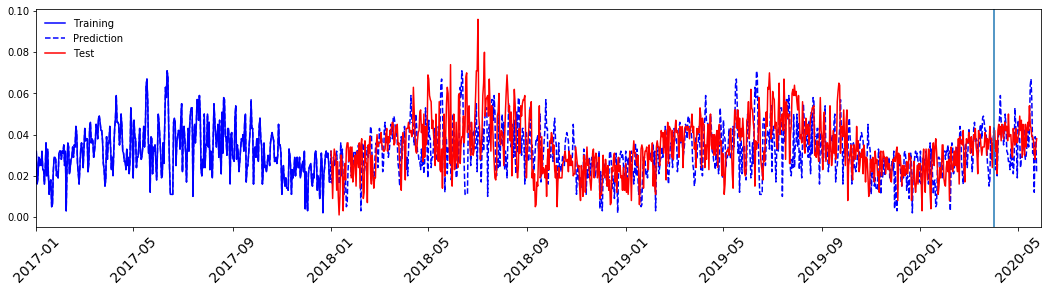

In [25]:
def PlotSeasonalNaivePrediction2(df, df_train, df_test, ifeature=1):
    
    cols=list(df.columns)
    cols.remove('Date')
    feature = cols[ifeature-1]
    plt.figure(figsize=(18,4))

    #plt.title('n_period (half year)='+str(n_period), fontsize=16, color='maroon' )

    df_pred = seasonal_naive2(df, df_train, df_test, 1, cols) # period=1 year
    plt.plot(df_train.Date, df_train[feature], 'b', label='Training')
    plt.plot(df_pred.Date,  df_pred[feature], 'b--', label='Prediction')
    plt.plot(df_test.Date,  df_test[feature], 'r', label='Test')
    plt.legend(frameon=False)
    plt.xlim (left=datetime(2017,1,1), right=df_test.Date[df_test.index[-1]] + timedelta(days=5) )
    plt.xticks(fontsize=14, rotation=45);
    plt.subplots_adjust(hspace=0.5)
    plt.axvline(x=datetime(2020, 4, 1))

PlotSeasonalNaivePrediction2(df_oz, df_train_oz, df_test_oz, ifeature=1)

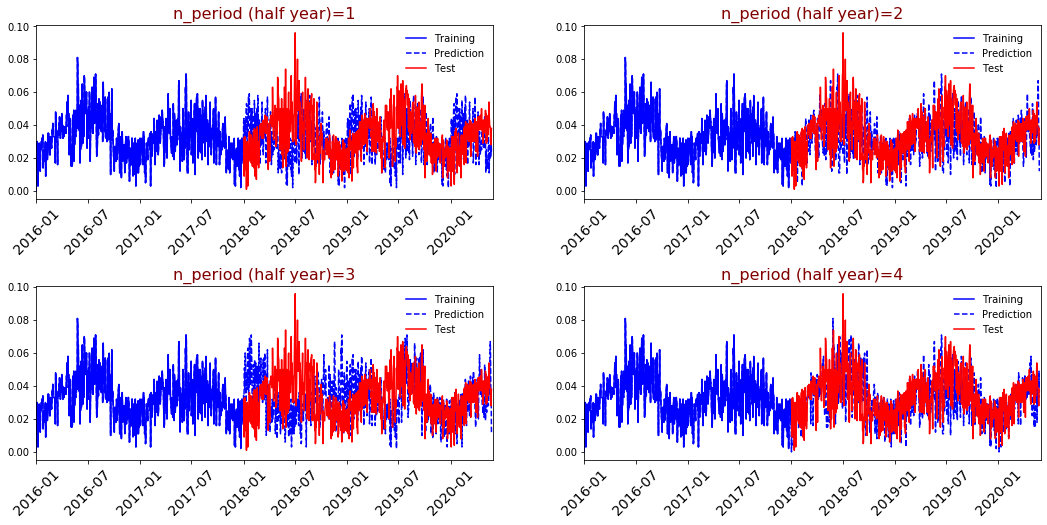

In [19]:
PlotSeasonalNaivePrediction(df_oz, df_train_oz, df_test_oz, ifeature=1)

In [9]:
def make_lag_df(df, feature, lag):
    lag_df = df.copy()
    lag_df[feature + '_lag'] = np.nan
    
    lag_df.loc[lag:,feature + '_lag'] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    return lag_df

def get_autocorr(df, feature, lag):
    df = make_lag_df(df, feature, lag)
    mean_y = df[feature].mean()
    
    y_ts = df[feature].values
    y_lags = df.dropna()[feature + '_lag'].values
    
    numerator = np.sum((y_ts[lag:] - mean_y)*(y_lags - mean_y))
    denom = np.sum(np.power(y_ts - mean_y,2))
    
    return numerator/denom

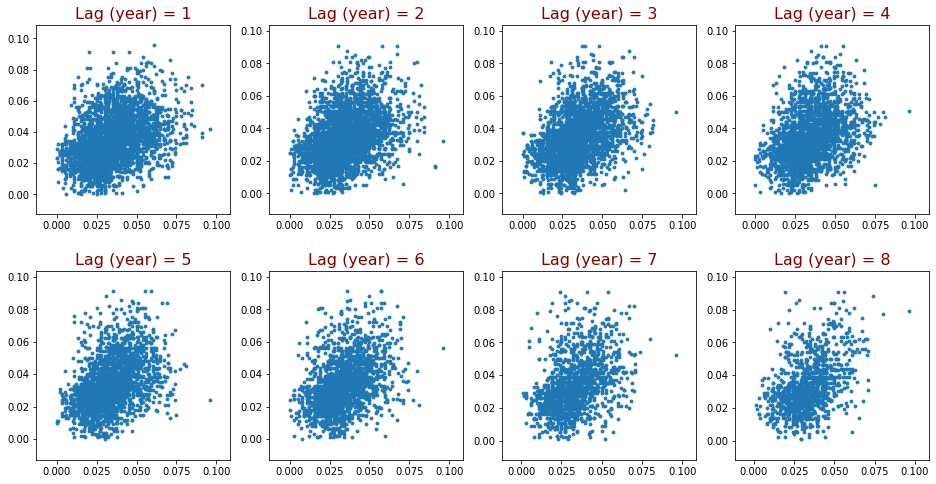

In [10]:
def Plot_Lag(df, ifeature, Nplots=8):
    feature=list(df.columns)[ifeature]
    plt.figure(figsize=(16,8))
    for i in range(1,Nplots+1):
        lag_df = make_lag_df(df, feature, i*365)

        plt.subplot(2,4, i)
        plt.title('Lag (year) = '+str(i), fontsize=16, color='maroon')
        plt.scatter(lag_df[feature], lag_df[feature+'_lag'], s=8)
        plt.subplots_adjust(hspace=0.3)
    plt.show()

Plot_Lag(df_oz, 1)

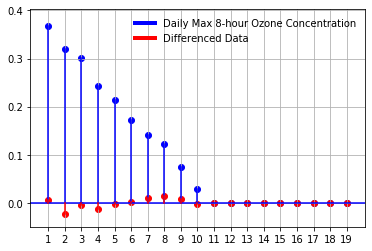

In [11]:
def Plot_autocorrelation(df, ifeature, N_year):
    feature=list(df.columns)[ifeature]
    
    autos = []
    for i in range(1,N_year,1):
        autos.append(get_autocorr(df,feature,i*365))
    plt.scatter(range(1,N_year,1), autos, c='b')

    for i in range(1,N_year,1):
        plt.plot(i*np.ones(2),[0,autos[i-1]],'b')

    plt.axhline(y=0, c='b')

    auto_diff = []
    diff_data = df.diff().dropna().reset_index(drop=True)

    for i in range(1,N_year,1):
        auto_diff.append(get_autocorr(diff_data,feature,i*365))

    plt.scatter(range(1,N_year,1), auto_diff, c='r')

    for i in range(1,N_year,1):
        plt.plot(i*np.ones(2),[0,auto_diff[i-1]],'r')
    plt.grid()

    plt.xticks(range(1,N_year));
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color="blue", lw=4),
                    Line2D([0], [0], color="red", lw=4)]

    plt.legend(custom_lines, [feature, 'Differenced Data'], frameon=False);

Plot_autocorrelation(df_oz, 1, 20)

In [12]:
# Try this for NO2 data for NJ

fname='datasets/NJ_NO2_site_0003.csv'
(df_no, df_train_no, df_test_no) = Prepare_Data(fname)

Dataset date range: 2011-01-13 2019-12-31
Number of missing dates in the dataset : 67 / 3208 
After filling the missing dates: the # of missing dates: 0


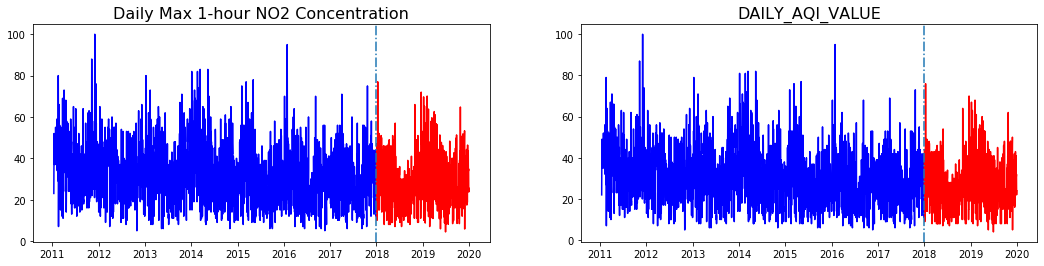

In [13]:
Plot_train_test(df_no, df_train_no, df_test_no)

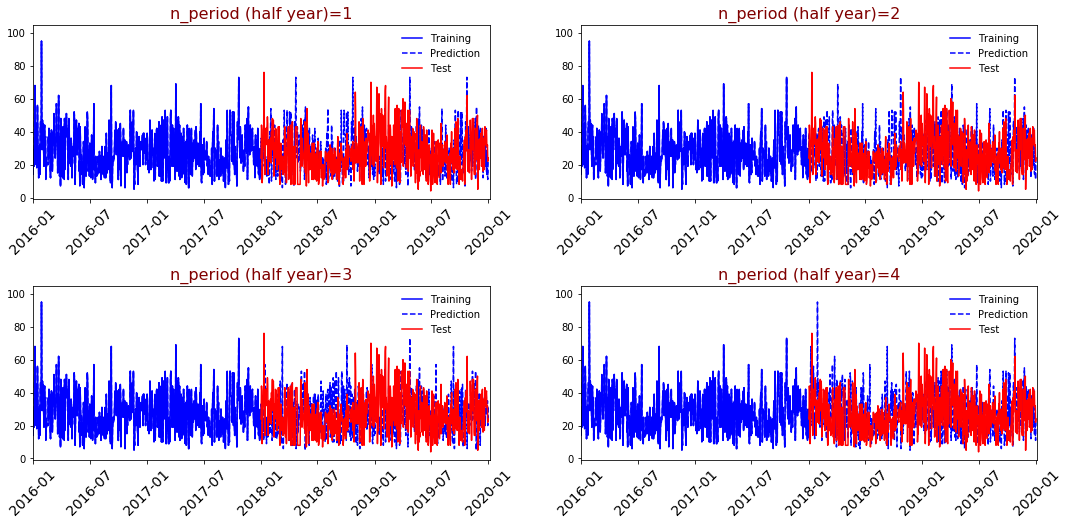

In [14]:
PlotSeasonalNaivePrediction(df_no, df_train_no, df_test_no, ifeature=1)

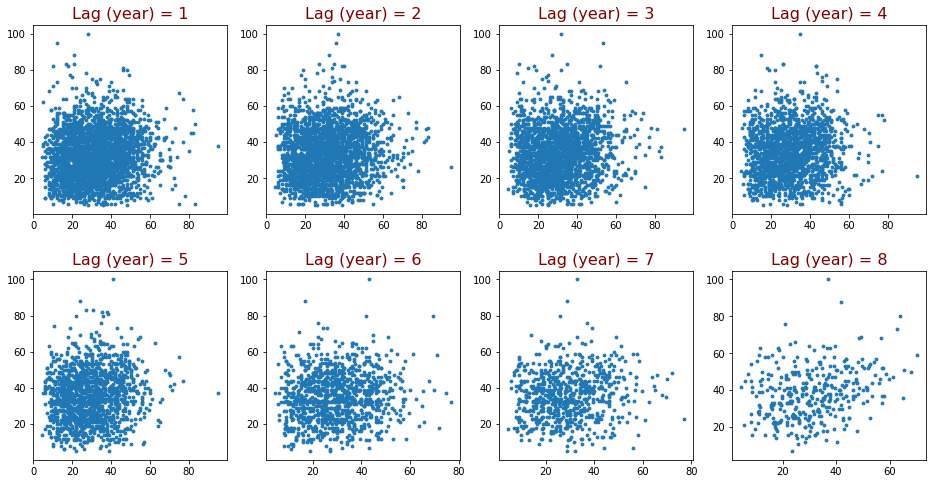

In [15]:
Plot_Lag(df_no, 1)

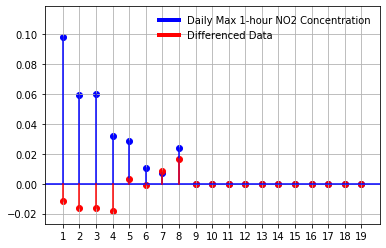

In [16]:
Plot_autocorrelation(df_no, 1, 20)